In [1]:
from glob import glob
import os
import h5py
import matplotlib.pyplot as plt
import numpy as np

from draco.core.io import get_telescope
from drift.core.manager import ProductManager

from ch_util import tools

In [2]:
# Load in the data file
filename = "/project/rpp-chime/areda26/stuff_for_other_people/hsiu-hsien/TauA_105/2667/TAU_A_2667_20181014T120212.h5"
f = h5py.File(filename, "r")
beam_dset = f["beam"] 
index_map = f['index_map']

In [3]:
# Hour angle axis
ha = index_map['pix'][:]['phi']

# Index of zero hour angle (i.e. transit)
zha = np.argmin(np.abs(ha))
n_time = len(ha)

In [4]:
# Frequency index
freq = index_map['freq'][:]

# Indices of frequencies of interest
fsel = np.arange(208, 215)
n_freq = len(fsel)

In [5]:
# Extract beam data set
beam_dset = f['beam'] # (freq, pol, feed, time)
beam = beam_dset[fsel]
weight_dset = f['weight']
weight = weight_dset[fsel]

# Normalize beams to 1 at zero hour angle
beam = beam * tools.invert_no_zero(beam[:,:,:,zha][:,:,:,np.newaxis])

In [8]:
cylprods = {
    "0": [("A", "A"), ("B", "B"), ("C", "C"), ("D", "D")],
    "1": [("A", "B"), ("B", "C"), ("C", "D")],
    "2": [("A", "C"), ("B", "D")],
    "3": [("A", "D")],
}

ycyls = {
    "A": (0, 256),
    "B": (512, 768),
    "C": (1024, 1280),
    "D": (1536, 1792),
}

xcyls = {
    "A": (256, 512),
    "B": (768, 1024),
    "C": (1280, 1536),
    "D": (1792, 2048),
}

allcyls = {"Y": ycyls, "X": xcyls}

cyl_seps = ["1", "2", "3"]

manager = ProductManager.from_config("/project/rpp-chime/chime/bt_empty/chime_4cyl_allfreq/")
tel = get_telescope(manager)

def process(beam, weight):

    nfreq, npol, _, npixel = beam.shape
    npol_prods = 4

    accumulate = np.zeros((nfreq, npol, npol_prods, npixel), dtype=np.complex64)
    count = np.zeros_like(accumulate, dtype=np.float32)

    # Mask anomalous samples. All inputs should be normalized to ~1 on
    # meridian.
    weight_mask = np.copy(weight).astype(int)
    weight_mask[np.abs(beam) > 2.0] = 0

    pol_axis = []

    for pp, (po, pcyls) in enumerate(allcyls.items()):

        pol_axis.append(po)

        for ew in cyl_seps:

            _mult_ew(ew, pp, po, pcyls, beam, weight_mask, accumulate, count)

    # Calling tools should be unecessary here, because draco version was broken for ints
    out_beam = accumulate * tools.invert_no_zero(count)

    return out_beam

def _mult_ew(
    ew,
    pp,
    po,
    pcyls,
    beam,
    weight_mask,
    acc,
    count,
):
    prodset = cylprods[ew]

    from itertools import product

    for (cyl1, cyl2) in prodset:

        # Iterate over co- and cross-products
        pol_prod = [0, 1]

        for prod, (pi, pj) in enumerate(product(pol_prod, pol_prod)):

            for ns in range(1, 255):

                st1, en1 = pcyls[cyl1]  # First and last input on cyl 1
                st2, en2 = pcyls[cyl2]  # "                         " 2

                st2 += ns  # Start second cyl ahead
                en1 -= ns  # End first cylinder same number of inputs behind

                pmask = np.where(
                    (po == tel.polarisation[st1:en1])
                    & (po == tel.polarisation[st2:en2]),
                    1,
                    0,
                )[:, np.newaxis]

                w_cyl1 = weight_mask[:, pi, st1:en1]
                w_cyl2 = weight_mask[:, pj, st2:en2]
                b_cyl1 = beam[:, pi, st1:en1]
                b_cyl2 = beam[:, pj, st2:en2]

                acc[:, pp, prod] += np.sum(
                    pmask * (w_cyl1 * b_cyl1) * np.conj(w_cyl2 * b_cyl2),
                    axis=1,
                )

                count[:, pp, prod] += np.sum(
                    pmask * w_cyl1 * w_cyl2,
                    axis=1,
                )

In [9]:
# Note this takes awhile to run
out = process(beam, weight)

In [75]:
out.shape # axes are: frequency, Y/X pol, copol-copol/copol-cross/cross-copol/cross-cross, HA
# you probably want to keep the third index set to 0 when looking at results

(7, 2, 4, 2160)

/tmp/ipykernel_958433/1794850307.py:6: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axes[ff].set_xlim(-50, 50)


Text(0.5, 0, 'HA [deg]')

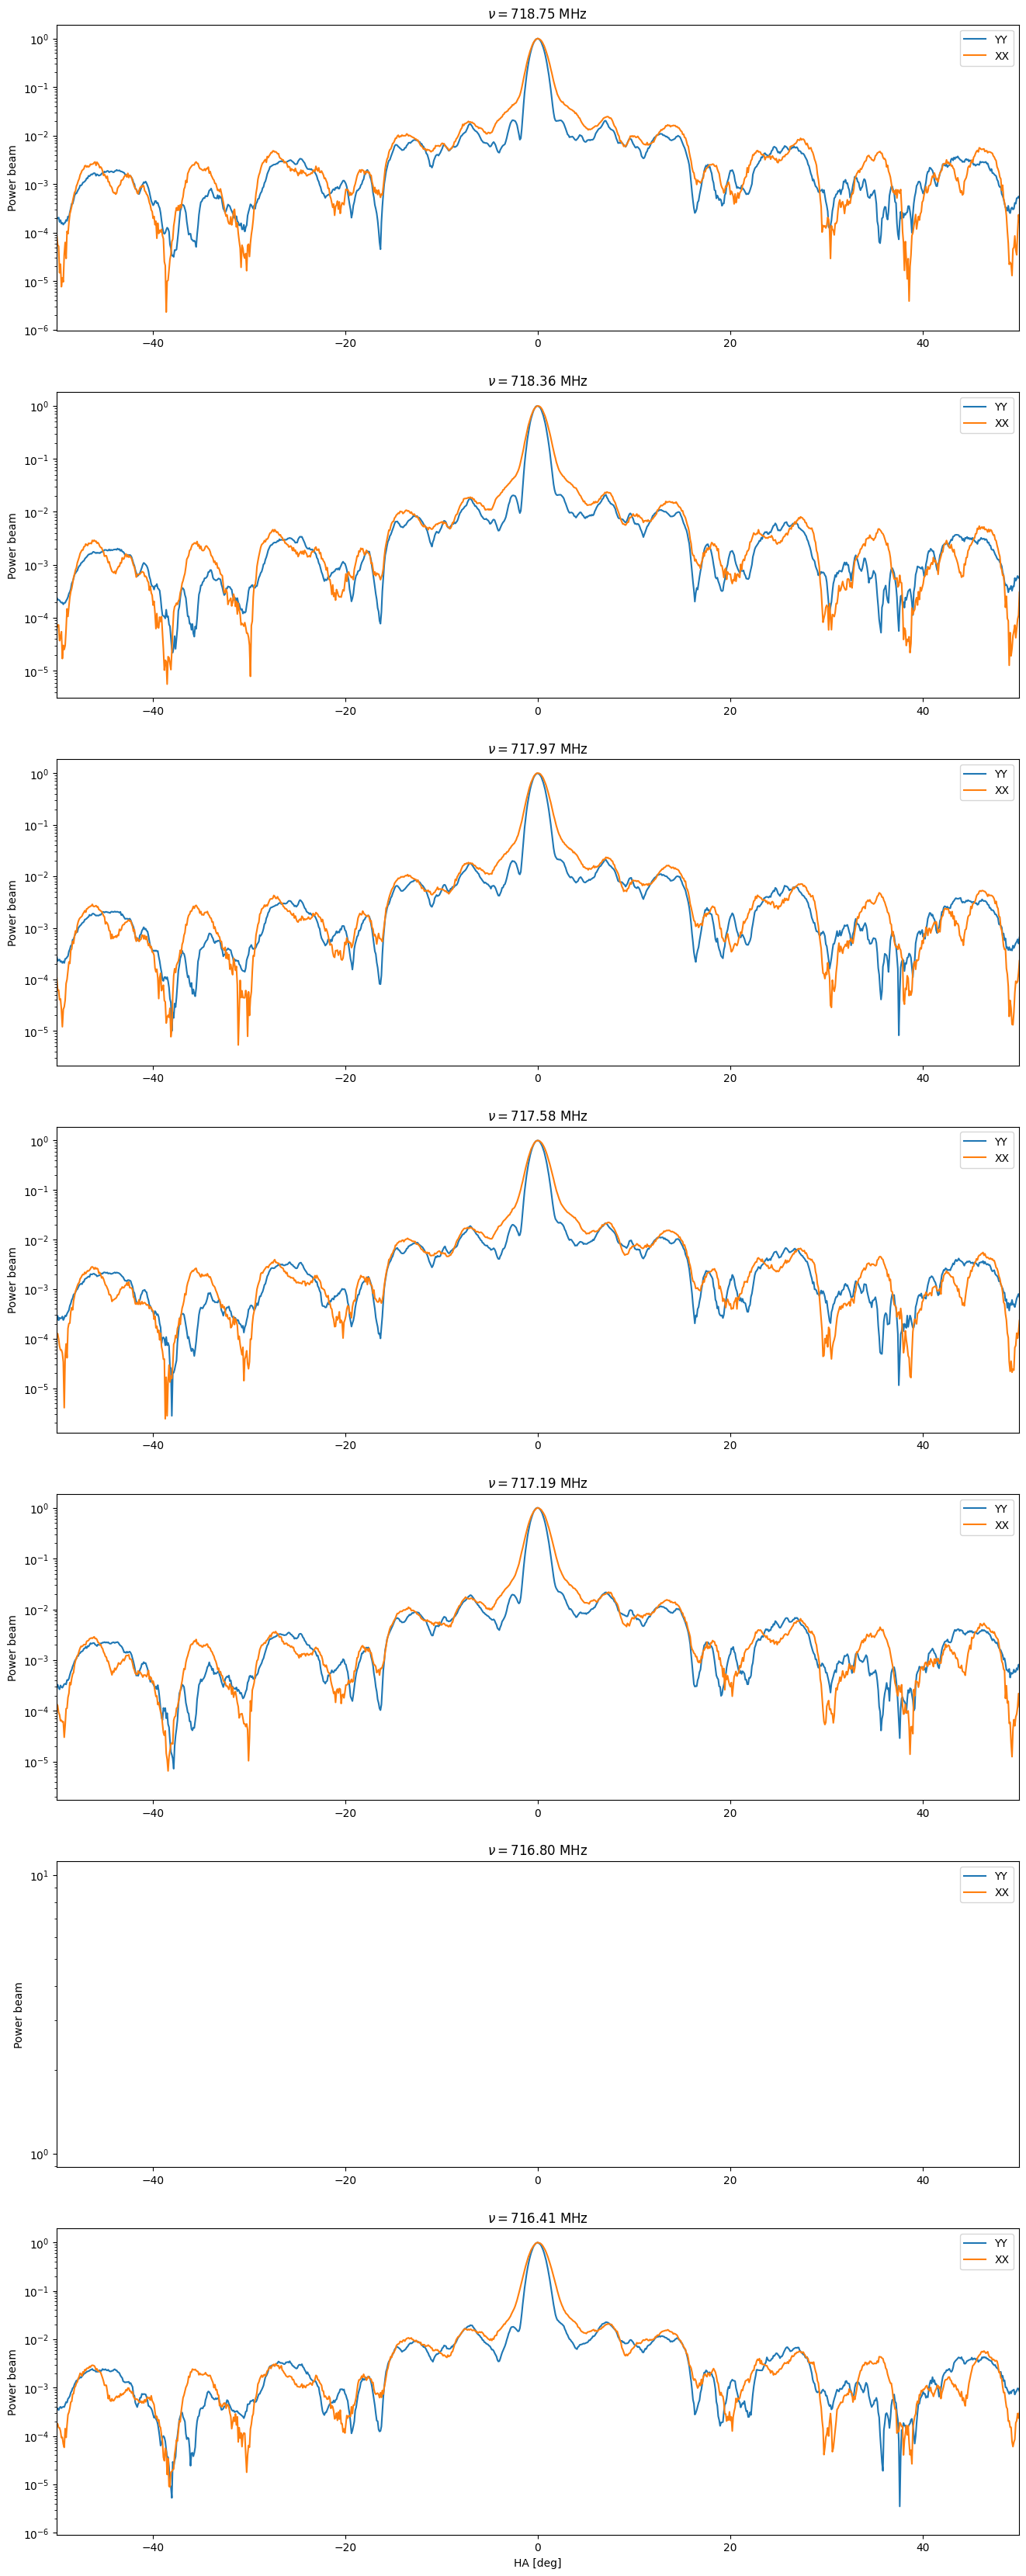

In [110]:
fig, axes = plt.subplots(figsize=(16, n_freq*6), nrows=n_freq, ncols=1)

for ff in range(n_freq):
    axes[ff].semilogy(ha, np.abs(out[ff, 0, 0]), label="YY")
    axes[ff].semilogy(ha, np.abs(out[ff, 1, 0]), label="XX")
    axes[ff].set_xlim(-50, 50)
    axes[ff].set_ylabel("Power beam")
    axes[ff].legend()
    axes[ff].set_title(rf"$\nu = {freq[fsel[ff]]:.2f}$ MHz")
    
axes[-1].set_xlabel("HA [deg]")